In [1]:
import requests
import warnings 
from urllib.request import urlopen
import time 
from bs4 import BeautifulSoup
import re
from  tqdm import tqdm
from datetime import datetime
import re
import pandas as pd

# 1. Data collection

## 1.1. Get the list of places

In [2]:
exception=[]  #In this list we store the exception in order to understand what is wrong.

#Since the link of the page contains number we use a for loop in order to change that number and so change the links.


for i in tqdm(range(1,401)):
    url='https://www.atlasobscura.com/places?page='+str(i)+'&sort=likes_count' #Move to the next web page 
    risposta=requests.get(url)                                                 #Request https protocolo        
    testo=BeautifulSoup(risposta.text,'html.parser')                           #Format the html
    
    try:
        first_div=testo.find_all("div",{"class":"row vue-js-bte-place-parent js-vue-component-wrap"}) #find the tag
        
        
        for j in range(0,len(first_div)):
            try:
                second_div=first_div[j].find_all("div",{"class":"col-md-4 col-sm-6 col-xs-12"})
    
                for k in range(0,len(second_div)):
                    try:
                        a=second_div[k].find("a").get("href").strip()    #extract the link of the page
                     
                        with open('links.txt',"a")as f:
                            f.write("https://www.atlasobscura.com"+str(a))  #write down on a txt file the complete link of the page.
                            f.write('\n')
                    except:
                        exception.append([i,j,k,risposta])      
            except:
                exception.append([i,j,None,risposta])   
    except:
        exception.append([i,None,None,risposta])
        
    
    time.sleep(1) #In ordere to avoid "429 Too Many Requests"
       
            
        

  0%|          | 1/400 [00:02<14:25,  2.17s/it]


KeyboardInterrupt: 

## 1.2. Crawl places

In [29]:
file = open('links.txt')
content = file.readlines()
for i in tqdm(range(0,len(content))):
    url=content[i].strip()    
    risposta=requests.get(url)                                               
    with open('HTML/html'+str(i)+'.txt',"a")as f:
        f.write(risposta.text)  #write down on a txt file the complete link of the page.
    time.sleep(1)


100%|██████████| 7200/7200 [2:18:44<00:00,  1.16s/it]  


## 1.3 Parse downloaded pages

### Function that extract data from single HTML

In [28]:
def estrazione(testo):  
    errors=[]
    #1 Place Name (to save as placeName): String.
    try:
        placeName=testo.find("h1",{"class":"DDPage__header-title"}).text.strip()
    except:
        placeName="Null"
        errors.append(1)
    #---#
    #2 Place Tags (to save as placeTags): List of Strings.
    try:
        placeTags=[]
        ff2=testo.find("div",{"class":"item-tags col-xs-12"})
        ff2=ff2.find_all("span")
        for i in range(len(ff2)):
            placeTags.append(ff2[i].find("a").text.strip())
    except:
        placeTags=[" "]
        errors.append(2)



    #---#
    conta=testo.find_all("div",{"class","title-md item-action-count"})

    #3 # of people who have been there (to save as numPeopleVisited): Integer.
    try:
        numPeopleVisited=conta[0].text.strip()
    except:
        numPeopleVisited=" "
        errors.append(3)
    #---#
    #4 # of people who want to visit the place(to save as numPeopleWant): Integer.    
    try:
        numPeopleWant=conta[1].text.strip()
    except:
        numPeopleWant=" "
        errors.append(4)
    #---#
    #5 Description (to save as placeDesc): String. Everything from under the first image up to "know before you go" (orange frame on the example image).
    try:
        tag=testo.find("div",{"class":"DDP__body-copy"})
        tag=tag.find_all("p")
        placeDesc=""
        for i in range(0,len(tag)):
            placeDesc += str(tag[i].text)
            
        placeDesc=placeDesc.replace("  ","")    
    except:
        placeDesc=""
        errors.append(5)

    #6 Short Description (to save as placeShortDesc): String. Everything from the title and location up to the image (blue frame on the example image).
    placeShortDesc=""
    try:
        placeShortDesc2=testo.find("h3", {"class","DDPage__header-dek"}).text.strip()
        
    except:
        placeShortDesc2=" "
        errors.append(6.2)
    placeShortDesc += placeShortDesc2
    
    placeShortDesc=placeShortDesc.replace("  ","")    
    #7 Nearby Places (to save as placeNearby): Extract the names of all nearby places, but only keep unique values: List of Strings.
    placeNearby=[]
    try:
        place=testo.find("div",{"class":"DDPageSiderail__column grid-col-lg-4 grid-col-md-5"})
        place=place.find("div",{"class":"DDPageSiderail"})
        place=place.find("div", {"class":"DDPageSiderailRecirc"})
        place=place.find_all("a")
        for i in range(0,len(place)):
            luogo=place[i].find("div",{"class":"DDPageSiderailRecirc__item-title"})
            placeNearby.append(luogo.text.strip())
    except:
        placeNearby=[" "]
        errors.append(7)
    #8 Address of the place(to save as placeAddress): String.
    try:
        placeAddress=testo.find("div",{"class":"DDPageSiderail__column grid-col-lg-4 grid-col-md-5"})
        placeAddress=placeAddress.find("div",{"class":"DDPageSiderail"})
        placeAddress=placeAddress.find("aside", {"class":"DDPageSiderail__details"})
        placeAddress0=placeAddress.find("address",{"class":"DDPageSiderail__address"})
        
        placeAddress=placeAddress0.find("div").get_text(",").strip().rstrip(',').strip()
  
       
    except:
        placeAddress=""
        errors.append(8)
    
    try:
              
        placeAddress1=str(placeAddress0.find("div"))
        a=placeAddress1.replace("<div>","")
        a=a.replace("</div>","")
        indirizzo,citta,stato=a.split("<br/>")
    except:
        try:
            stato=placeAddress.split(",")
            stato=stato[len(stato)-1]
            indirizzo="Not available"
            citta="Not available"     
        except:
            indirizzo="Not available"
            citta="Not available"
            stato="Not available"
        
    
    #9 Altitude and Longitude of the place's location(to save as placeAlt and placeLong): Integers
    try:
        coordinate=testo.find("div",{"class":"DDPageSiderail__column grid-col-lg-4 grid-col-md-5"})
        coordinate=coordinate.find("div",{"class":"DDPageSiderail"})
        coordinate=coordinate.find("aside", {"class":"DDPageSiderail__details"})
        coordinate=coordinate.find("div",{"class":"DDPageSiderail__coordinates js-copy-coordinates"}).text.strip().split()

        placeAlt=float(coordinate[0].replace(",",""))
        placeLong=float(coordinate[1].replace(",",""))
    except:
        placeAlt=" "
        placeLong=" "
        errors.append(9)

    #10 The username of the post editors (to save as placeEditors): List of Strings
    placeEditors=[]
    createdby=[]
    Editors=testo.find("div",{"id":"ugc-module"})
    Editors=Editors.find("div",{"class":"DDPContributors"})
    Editors=Editors.find_all("div",{"class":"ugc-editors"})

    try:
        for i in range(0,len(Editors)):
            tipo=Editors[i].find("h6").text.strip()
            if "edited by" == tipo.lower():
                try:
                    g=Editors[i].find("div",{"class":"DDPContributorsList"})
                    g=g.find("div",{"class":"js-editor-list hidden"})
                    g=g.find_all("li")
                    for  i in range(0,len(g)):
                        a=g[i].find("a").find("span").text.strip()
                        placeEditors.append(a)
                except:
                    placeEditors=[" "]
                    #errors.append(10.1)
                    
            elif "added by"==tipo.lower():
                try:
                    creator=Editors[i].find("div",{"class":"DDPContributorsList"})
                    createdby.append(creator.find("a").text)
                except:
                    createdby=[" "]
                   # errors.append(10.2)
    except:
        createdby=[" "]
        placeEditors=[" "] 
        errors.append(10)
    placeEditors=",".join(placeEditors)
    createdby=",".join(createdby)


    #11 Post publishing date (to save as placePubDate): datetime.
    try:
        placePubDate=testo.find("div",{"id":"ugc-module"})
        placePubDate=placePubDate.find("div",{"class":"DDPContributors"})
        placePubDate=placePubDate.find("div",{"class":"DDPContributor__name"}).text.strip()
        placePubDate=datetime.strptime(placePubDate, "%B %d, %Y").date() #year, month, day
    except:
        placePubDate=" "
        errors.append(11)

    #12 The names of the lists that the place was included in (to save as placeRelatedLists): List of Strings.
    placeRelatedLists=[]
    try:
        o=testo.find_all("div",{"class":"card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"})
        o=o[2].find_all("div",{"class":"CardWrapper js-CardWrapper"})
        for i in range(len(o)):
            m=o[i].find("h3").text.strip()
            placeRelatedLists.append(m)
    except:
        placeRelatedLists=[" "]
        errors.append(12)

    #13 The names of the related places (to save as placeRelatedPlaces): List of Strings.
    placeRelatedPlaces=[]
    try:
        o=testo.find_all("div",{"class":"card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"})
        o=o[1].find_all("div",{"class":"CardWrapper js-CardWrapper"})
        for i in range(len(o)):
            m=o[i].find("h3").text.strip()
            placeRelatedPlaces.append(m)
    except:
        placeRelatedPlaces=[" "]
        errors.append(13)

    #14 The URL of the page of the place (to save as placeURL):String
    try:
        placeURL=testo.find("link",{"rel":"canonical"}).get("href")
    except:
        placeURL=" "
        errors.append(14)
    
    

    try:
        link=testo.find("div",{"class":"DDPage__header-place-location"})
        link=link.find("a").get("href").strip()
    except:
        link=" "
       
    
    d={"placeName":placeName,"placeTags": ",".join(placeTags),"numPeopleVisited":int(numPeopleVisited),"numPeopleWant":int(numPeopleWant),"placeDesc":placeDesc,"placeShortDesc":placeShortDesc,
    "placeNearby":",".join(placeNearby),"placeAddress":placeAddress.strip(),"placeAlt":placeAlt,"placeLong":placeLong,"createdby":createdby,"placeEditors":placeEditors,"placePubDate":placePubDate,
    "placeRelatedLists":",".join(placeRelatedLists),"placeRelatedPlaces":",".join(placeRelatedPlaces),"placeURL":placeURL}
    
    d_indirizzo={"placeName":placeName,"placeTags": ",".join(placeTags),"numPeopleVisited":int(numPeopleVisited),"numPeopleWant":int(numPeopleWant),"placeDesc":placeDesc,"placeShortDesc":placeShortDesc,
    "placeNearby":",".join(placeNearby),"placeAddress":placeAddress.strip(),"placeAlt":placeAlt,"placeLong":placeLong,"createdby":createdby,"placeEditors":placeEditors,"placePubDate":placePubDate,
    "placeRelatedLists":",".join(placeRelatedLists),"placeRelatedPlaces":",".join(placeRelatedPlaces),"placeURL":placeURL,"Address":indirizzo.strip(),"City":citta.strip(),"State":stato.strip()}
    
    return  d,errors,d_indirizzo    

## Create dataframe

#### Create 7200 tsv files, place_i.tsv and one csv file

In [29]:
anomalie={}
for i in tqdm(range(0,7200)):
    
    with open('HTML_scraping/html'+str(i)+'.txt') as f:
        testo = f.read()

    testo=BeautifulSoup(testo,'html.parser') 
    d,errori,d_indirizzo=estrazione(testo)
    
    if len(errori) != 0:
        anomalie[str(i)]=errori
        
    df=pd.DataFrame(d,index=[0])
   
    
    df.to_csv("TSV_data/place_"+str(i)+".tsv",sep="\t")
    if i==0 :
      dfff=pd.DataFrame(d,index=[i])
      dfff_indirizzo=pd.DataFrame(d_indirizzo,index=[0])
    
    else:
      dataframe=pd.DataFrame(d,index=[i])
      dfff=pd.concat([dfff,dataframe])
        
        
      dataframe_indirizzo=pd.DataFrame(d_indirizzo,index=[i])
      dfff_indirizzo=pd.concat([dfff_indirizzo,dataframe_indirizzo])
        
dfff.to_csv("places4.csv",sep="\t")
dfff_indirizzo.to_csv("address.csv",sep="\t")

100%|███████████████████████████████████████| 7200/7200 [10:45<00:00, 11.15it/s]


#### Overview of the dataset

In [4]:
df=pd.read_csv("places4.csv",delimiter="\t")
df.head(5)

Unnamed: 0            placeName  \
0           0    City Hall Station   
1           1    Highgate Cemetery   
2           2    Leadenhall Market   
3           3       The Wave Organ   
4           4  Catacombes de Paris   

                                           placeTags  numPeopleVisited  \
0  subways,subterranean,infrastructure,subterrane...              1824   
1  rivals week,vampires,hoaxes,occult,catacombs,c...              2613   
2                        markets,film locations,film              3131   
3  sea organ,aletrail,sounds,music,outsider art,c...              2426   
4  ossuaries,memento mori,catacombs and crypts,su...              4438   

   numPeopleWant                                          placeDesc  \
0           8564  The first New York City subway was built and o...   
1           8174  Opened in 1839, Highgate is one of London’s mo...   
2           7554  The ornate 19th-century painted roof and cobbl...   
3           7398  Located on a jetty in the San Francisco Bay, t...   
4           7032  In 2004, Parisian police were assigned to do a...   

                                      placeShortDesc  \
0  A beautiful and abandoned New York subway stat...   
1  London's creepiest cemetery was once the site ...   
2  This ornate Victorian marketplace was the sett...   
3     A huge musical instrument played by the ocean.   
4  The vast, legendary catacombs hold secrets muc...   

                                         placeNearby  \
0  African Burial Ground National Monument,Tunnel...   
1  World's Largest Potted Plant,Dick Whittington’...   
2  The Cornhill Devils,London's Original and All-...   
3  Long Now Orrery,The Stern of the Brigantine Ga...   
4  Sculptures de Décure,Arago Medallions,Jeannot'...   

                                        placeAddress  placeAlt  placeLong  \
0  31 Centre St,New York, New York, 10007,United ...   40.7134   -74.0046   
1  Swain's Lane, Highgate,London, England, N6,Uni...   51.5675    -0.1483   
2               London, England, EC3V,United Kingdom   51.5126    -0.0834   
3  83 Marina Green Dr,San Francisco, California, ...   37.8085  -122.4401   
4      1 Place Denfert-Rochereau,Paris, 75014,France   48.8343     2.3322   

      createdby                                       placeEditors  \
0  Rebekah Otto  charding407,fosterc827,Mike H,erjeffery,Allan,...   
1           NaN  thesecretcity,thedyerghoulhouse,juliapetrushen...   
2           Meg  Julius Spada,Katecrimson,thesecretcity,jules 1...   
3        mbison  routt1111,wefiddleboy14,Saal333,Neighborhood S...   
4      CPilgrim  marypippen,ramonrodz2212,mathewbrowne,Fred Che...   

  placePubDate                                  placeRelatedLists  \
0   2010-05-08  30 Unexpected Places to Have a Joyful Adventur...   
1   2014-08-09  The World's Top 100 Wonders in 2018,London's T...   
2   2016-08-01  The Ultimate Guide to Stunning, Surprising, or...   
3   2008-11-21  Leonardo Nam's 16 Quirky Roadside Attractions,...   
4   2009-02-13  19 Catacombs Sure to Tingle Your Spine,The Wor...   

                                  placeRelatedPlaces  \
0  Crystal Palace Subway,Moscow Metro Stations,Ro...   
1  Jewett City Vampires,Tomb of the Mather Family...   
2  Rivendell,Bagdad Cafe,Gare de la Ciotat,Drvengrad   
3  Sea Organ,Silent Green Kulturquartier,St. John...   
4  Ossario di San Martino,Leuk Charnel House,Sant...   

                                            placeURL  
0  https://www.atlasobscura.com/places/city-hall-...  
1  https://www.atlasobscura.com/places/highgate-c...  
2  https://www.atlasobscura.com/places/leadenhall...  
3     https://www.atlasobscura.com/places/wave-organ  
4  https://www.atlasobscura.com/places/catacombes...

This second version of the dataframe is an optional one. We built this dataframe in order to simplify our work for the point 4 of the homework in which we have to visualize on a map all over the plces from the data set. In this way we decided to extrapolate from the _place address_ of each place information like the city and the country splitting the original attribute in other secondary attributes of the dataframe.

In [3]:
df=pd.read_csv("address.csv",delimiter="\t")
df.head(5)

Unnamed: 0.1  Unnamed: 0            placeName  \
0             0           0    City Hall Station   
1             1           1    Highgate Cemetery   
2             2           2    Leadenhall Market   
3             3           3       The Wave Organ   
4             4           4  Catacombes de Paris   

                                           placeTags  numPeopleVisited  \
0  subways,subterranean,infrastructure,subterrane...              1824   
1  rivals week,vampires,hoaxes,occult,catacombs,c...              2613   
2                        markets,film locations,film              3131   
3  sea organ,aletrail,sounds,music,outsider art,c...              2426   
4  ossuaries,memento mori,catacombs and crypts,su...              4438   

   numPeopleWant                                          placeDesc  \
0           8564  The first New York City subway was built and o...   
1           8174  Opened in 1839, Highgate is one of London’s mo...   
2           7554  The ornate 19th-century painted roof and cobbl...   
3           7398  Located on a jetty in the San Francisco Bay, t...   
4           7032  In 2004, Parisian police were assigned to do a...   

                                      placeShortDesc  \
0  A beautiful and abandoned New York subway stat...   
1  London's creepiest cemetery was once the site ...   
2  This ornate Victorian marketplace was the sett...   
3     A huge musical instrument played by the ocean.   
4  The vast, legendary catacombs hold secrets muc...   

                                         placeNearby  \
0  African Burial Ground National Monument,Tunnel...   
1  World's Largest Potted Plant,Dick Whittington’...   
2  The Cornhill Devils,London's Original and All-...   
3  Long Now Orrery,The Stern of the Brigantine Ga...   
4  Sculptures de Décure,Arago Medallions,Jeannot'...   

                                        placeAddress  ...  placeLong  \
0  31 Centre St,New York, New York, 10007,United ...  ...   -74.0046   
1  Swain's Lane, Highgate,London, England, N6,Uni...  ...    -0.1483   
2               London, England, EC3V,United Kingdom  ...    -0.0834   
3  83 Marina Green Dr,San Francisco, California, ...  ...  -122.4401   
4      1 Place Denfert-Rochereau,Paris, 75014,France  ...     2.3322   

      createdby                                       placeEditors  \
0  Rebekah Otto  charding407,fosterc827,Mike H,erjeffery,Allan,...   
1           NaN  thesecretcity,thedyerghoulhouse,juliapetrushen...   
2           Meg  Julius Spada,Katecrimson,thesecretcity,jules 1...   
3        mbison  routt1111,wefiddleboy14,Saal333,Neighborhood S...   
4      CPilgrim  marypippen,ramonrodz2212,mathewbrowne,Fred Che...   

  placePubDate                                  placeRelatedLists  \
0   2010-05-08  30 Unexpected Places to Have a Joyful Adventur...   
1   2014-08-09  The World's Top 100 Wonders in 2018,London's T...   
2   2016-08-01  The Ultimate Guide to Stunning, Surprising, or...   
3   2008-11-21  Leonardo Nam's 16 Quirky Roadside Attractions,...   
4   2009-02-13  19 Catacombs Sure to Tingle Your Spine,The Wor...   

                                  placeRelatedPlaces  \
0  Crystal Palace Subway,Moscow Metro Stations,Ro...   
1  Jewett City Vampires,Tomb of the Mather Family...   
2  Rivendell,Bagdad Cafe,Gare de la Ciotat,Drvengrad   
3  Sea Organ,Silent Green Kulturquartier,St. John...   
4  Ossario di San Martino,Leuk Charnel House,Sant...   

                                            placeURL  \
0  https://www.atlasobscura.com/places/city-hall-...   
1  https://www.atlasobscura.com/places/highgate-c...   
2  https://www.atlasobscura.com/places/leadenhall...   
3     https://www.atlasobscura.com/places/wave-organ   
4  https://www.atlasobscura.com/places/catacombes...   

                     Address                              City           State  
0               31 Centre St         New York, New York, 10007   United States  
1     Swain's Lane, Highgate           

#### Analysis of the errors

We record every single lack of information and error in a .txt file reporting the type of anomaly (with representative code) and the indexes in which the anomaly occurs.

In [41]:
with open('anomalie.txt',"w")as f:
    for i in anomalie.keys():
        f.write(i)
        f.write(str(anomalie[i]))
        f.write("\n")

# 2. Search Engine

In [2]:
import pandas as pd
import json
import re
import spacy
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from functools import reduce
from  tqdm import tqdm
import math
from IPython.display import display, HTML
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
from nltk.stem import PorterStemmer  

     ---------------------------------------- 12.8/12.8 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
webdata = pd.read_csv("places4.csv",delimiter="\t")

## Pre-processing data

We define this phase as data pre-processing in that we intend to "clean up" the data at our disposal, making it more user-friendly and trying to make real changes to the set of terms contained in the documents being analyzed and the input query:

1. For first we stem words i.e., we reduce the length of individual words by removing the ending -> thus we do not differentiate between terms that have a different logical role in the sentence but refer to the same topic;

2. We remove the so-called "stop words" -> terms that are not indicative of the real content of a text but appear many times in it (e.g. "and", "or " , "if" ...);

3. Then we remove some punctuation and special characters;

4. Finally, we try to "package" the terms contained in each place description (which we recall is data in textual form i.e. unstructured data) into a data structure that is simple but can provide a minimum of hierarchy and indexing (a list) -> in this way it will be easier for us to manage the terms for building the retrieval model.



In [4]:
def stem_text(txt):
    stemmer = PorterStemmer()
    doc = nlp(txt.lower())
    return [re.sub("[”“/}/(/)/{!?\]\[#@]","",stemmer.stem(token.lemma_)) for token in doc if not token.is_punct and token.pos_ not in ['DET', 'CCONJ']]

webdata['list_words'] = webdata.placeDesc.apply(lambda row: stem_text(row))
#webdata['list_words'] = webdata.placeShortDesc.apply(lambda row: stem_text(row))

## Building the retrieval model

### Creating the vocabulary of our collection

First, we construct a vocabulary containing the set of terms found in the entire document collection. In addition, the vocabulary reports as the value of each term (key) a statistical information that will come in handy in Section 2.2, namely the document frequency of the term itself ($ df_{t}$). 

With $ df_{t}$ we indicate the number of documents which conatains the term $t$

In [5]:
vocabulary=Counter(reduce(lambda x, y: x + y, webdata.list_words))

### Assigning indexes to each term in our vocabulary

In [6]:
word_dict = {}
item_id = 1
for word in vocabulary.keys():
    word_dict[word] = item_id
    item_id += 1

### Building the inverted index structure

The inverted index is "an index that maps back from terms to the parts of a document where they occur" (definition from the book "Information retrieval").
To represent this information we choose a dictionary data structure in which:

>- each **key** is a term from our vocabulary;

>- each **value** consists of the _postings list_ of the key, i.e. a list wich contains all the indexes of the documents in which the term occurs.

In [7]:
inverted_idx = {}
for word, item_id in word_dict.items():
    inverted_idx[item_id] = list(webdata[webdata.list_words.apply(lambda row: word in row)].index)

### Defining the _tf-idf_

We assign to each term in a document a weight for that term, that depends on:

>- $tf_{t,d}$ -> the **Term frequency**, i.e. the number of occurrences of the term in the document;

>- $df_{t}$ -> the **Document ferquency**, i.e the total number of occurrences of a term in the collection;

>- $idf_{t}$ -> the **Inverse document frequency** that derives from the index above and it is useful for attenuating the effect of terms that occur too often in the collection to be meaningful for relevance determination. It is defined as $\log \frac{N}{\mathrm{df}_t}$

Thus the definitive weight of the term _t_ in the document _d_ is:

$$ {tf-idf}_{t,d} = tf_{t,d} \cdot idf_{t}

### Building the vector space model

A vector space model consists of:

>- a representation of documents as vectors with one component corresponding to each term in the vocabulary -> each component of a document in the vectorized form is _tf-idf_ of a term in the vocabulary;

>- the query (seen as a bag of words that we want to check in the collection) also is a vector defined like above;

>- we want to check the similarity between these two vectors using the **cosine similarity** -> we assign to each document _d_ a _score_ with respect to the query _q_ defined as the dot product of the two vectors normalized by the product of their norms --> 
$\operatorname{CosineSim}\left(d_1, d_2\right)=\frac{\vec{V}\left(d_1\right) \cdot \vec{V}\left(d_2\right)}{\left|\vec{V}\left(d_1\right)\right|\left|\vec{V}\left(d_2\right)\right|}$


Summing up: we view a collection of N documents as a collection of vectors that we call _term-document matrix_ whose rows represents represents the N documents and columns represents the M terms of the entire vocabulary.

In [12]:
tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text:  text)
result = tfidf.fit_transform(webdata.list_words)
result_dense = result.todense()
results_dense_list = result_dense.tolist()

In [13]:
df=pd.DataFrame(results_dense_list, index=webdata.index, columns=tfidf.get_feature_names())

c:\Users\engri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Visualizing the _term-document matrix_

In [14]:
df

\n         $    +  +31020  +420  ,the  -20  -24  -321  ...  ″trainers″  \
0     0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
1     0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
2     0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
3     0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
4     0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
...   ...  ...  ...  ...     ...   ...   ...  ...  ...   ...  ...         ...   
7195  0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
7196  0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
7197  0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
7198  0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   
7199  0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0   0.0  ...         0.0   

      ″welcom    €    ™    →  万里长城  奥武島  猫神社   畳石  高徳院  
0         0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
1         0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
2         0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
3         0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
4         0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
...       ...  ...  ...  ...   ...  ...  ...  ...  ...  
7195      0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
7196      0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
7197      0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
7198      0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  
7199      0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  

[7200 rows x 56170 columns]

## 2.1 Conjunctive query 

With a conjunctive query we simply intend to find the documents that contains all the terms of our query. We can answer a conjunctive query using the inverted index structure and the basic _Boolean retrieval model_ and considering the query as a series of single boolean queries related with a "logic and".
The overall process is defined as follows:

    For term in query:
        Locate the term in the inverted index dictionary
        Retrieve its postings and add them to a set of indexes
    Intersect all the sets represinting the posting lists each term of the query.

WARNING: we assume that if a word have a tfidf different from zero the word is in that document.
So we use directly the term-document matrix with the td-idfs. 

In [8]:
#query_str = "and from york beauti"
query_str="new york beautiful dog"
#query_str = "and   from yotk beauti"

query_str=re.sub("\s{2,}"," ",query_str)  #Remove double spaces
results = [inverted_idx[item] for item in [word_dict[word] for word in stem_text(query_str) if word in vocabulary]]

In [15]:
from IPython.display import display, HTML

parole=[word for word in stem_text(query_str)]
check_parole=[word for word in stem_text(query_str) if word in vocabulary]

if len(parole)== len(check_parole):
    indici=list(df[stem_text(query_str)][(df[stem_text(query_str)].T != 0).all()].index)
    
    display(HTML(webdata[webdata.index.isin(indici)][["placeName","placeDesc","placeURL"]].to_html()))
else:
    print("Can't find a document that contain all the word in the query, check input for misspelled words.")

## 2.2 Conjunctive query & Ranking score

Now we report the process of ranking the documents resulting from the conjunctive query sorting them by cosine similarity.
Steps:

1. vectorize the query and evaluate the tf-idf of the terms in the query;

2. compare the query with each row of the term-document matrix and evaluate the score as the cosine similarity of the _d_ and _q_ vectors;

3. we assign to each document a corresponding score attribute;

4. sort the documents by their score.

In [16]:
def querty_td_idf(query_str):
    #Inizialize dataset
    td_inf={}
    
    #Remove double spaces
    query_str=re.sub("\s{2,}"," ",query_str)
    
    #Stem the query
    stemmed_query=stem_text(query_str)
    
    
    word_in_query=set(stemmed_query)
    
    
    for word in word_in_query:
    
        
        #DF document frequency
        df_t=vocabulary[word]
        if df_t==0:
            raise Exception("Can't find a document that contain all the word in the query, check input for misspelled words.")
           # raise Value Error("Can't find a document that contain all the word in the query, check input for misspelled words.")
            #print("Can't find a document that contain all the word in the query, check input for misspelled words.")
            #return None
        else:
    
            #TF
            ##occurence of t word in the query
            t_in_document=" ".join(stemmed_query).count(word) #count on total query or stemmed query? for now stemmed query


            ##Word in  the query
            parole_in_d=len(stemmed_query) #count on stemmed query or total query?for now stemmed query

            tf=t_in_document/parole_in_d
            
            #DF document frequency
            #df_t=vocabulary[word]
            results = [inverted_idx[item] for item in [word_dict[word] for word in stemmed_query if word in vocabulary]]
            df_t=len(results)

            #Inverse document frequency
            #N=len(df)
            N=7200
            idf=math.log(N/(df_t+1))


            #TD-INF
            td_inf_i=tf* idf

            td_inf[word]=td_inf_i  #dictionary of td_idf for every word in the query

    dataset=pd.DataFrame([td_inf])
    return dataset

### Run the query

In [18]:
query_str="dog new york "
def searchEngine(query,k):
    

   
    query=re.sub("\s{2,}"," ",query)

    parole=[word for word in stem_text(query)]
    check_parole=[word for word in stem_text(query) if word in vocabulary]

    if len(parole)== len(check_parole):

        indici=list(df[stem_text(query)][(df[stem_text(query)].T != 0).all()].index)




        #Inizialize a list for store the value of cosine_similarity
        list_cosine_similarity=[]

        #Define a new dataset. In this dataset we will add the cosine similarity.
        data=webdata[webdata.index.isin(indici)][["placeName","placeDesc","placeURL"]]


        #Define a new dataset. In this dataset we will put the tf-idf of the matching documents.
        a=df[df.index.isin(indici)][stem_text(query)]
        a=a.reindex(sorted(a.columns), axis=1) 

        #Evaluate tf-idf of query
        td_idf_query=querty_td_idf(query)
        td_idf_query=td_idf_query.reindex(sorted(a.columns), axis=1) 



        #Evaluate cosine similarity between each document and the query.


        for i,row in a.iterrows():


            num=np.dot(td_idf_query.values.flatten(),row.values)
            den=np.linalg.norm(td_idf_query.values.flatten()) * np.linalg.norm(row.values)

            cosine=num/den
            list_cosine_similarity.append(cosine)

        data["Similarity"]= list_cosine_similarity
        display(HTML(data.sort_values("Similarity",ascending=False).head(k).to_html()))
        return data.head(k)


    else:
        print("Can't find a document that contain all the word in the query, check input for misspelled words.")
df_1=searchEngine(query_str,4)

# 3. Define a new score!

In the cells below we can see that often (especially in the case of queries of only one or a few terms) many places get the same level of similarity. Therefore, we decided to implement a new scoring system based on the popularity of a place with respect to website users. In this case we define the new score as follows:

$$ NewScore(q,d) = CosineSimilarity(q,d) \cdot 0.5 \cdot (P_d/Pmax) \cdot (V_d/Vmax) $$

where:
>- $P_d$ = # of people that want to visit the place corresponding to the document d
>- Pmax = max # of people that want to visit a place in the collection of places
>- $V_d$ =  # of people that want visited the place corresponding to the document d
>- Vmax =  = max # of people that visited a place in the collection of places

#### Dataframe version

In this first version of our new scoring system the function returns as output directly the top-k documents of a new dataframe difined as the orginal one with a place per row but an attribute in addition that represents the relative score

In [19]:
def searchEngineNew(query,k):
    query=re.sub("\s{2,}"," ",query)

    parole=[word for word in stem_text(query)]
    check_parole=[word for word in stem_text(query) if word in vocabulary]

    if len(parole)== len(check_parole):

        indici=list(df[stem_text(query)][(df[stem_text(query)].T != 0).all()].index)




        #Inizialize a list for store the value of cosine_similarity
        list_cosine_similarity=[]

        #Define a new dataset. In this dataset we will add the cosine similarity.
        data=webdata[webdata.index.isin(indici)][["placeName","placeDesc","placeURL",'numPeopleWant','numPeopleVisited']]
        
        #Normalize the numPeopleWant and the numPeopleVisited columns
        data['numPeopleWant'] = data['numPeopleWant'] /data['numPeopleWant'].abs().max()
        data['numPeopleVisited'] = data['numPeopleVisited'] /data['numPeopleVisited'].abs().max()



        #Define a new dataset. In this dataset we will put the tf-idf of the matching documents.
        a=df[df.index.isin(indici)][stem_text(query)]
        a=a.reindex(sorted(a.columns), axis=1) 

        #Evaluate tf-idf of query
        td_idf_query=querty_td_idf(query)
        td_idf_query=td_idf_query.reindex(sorted(a.columns), axis=1) 



        #Evaluate cosine similarity between each document and the query.


        for i,row in a.iterrows():


            num=np.dot(td_idf_query.values.flatten(),row.values)
            den=np.linalg.norm(td_idf_query.values.flatten()) * np.linalg.norm(row.values)

            cosine=num/den
            list_cosine_similarity.append(cosine)
            

        data["Score"]= list_cosine_similarity
        #Adjust the weight as the similarity is more important than a place's popularity
        data['Score']=data['Score']*(0.5*data['numPeopleVisited']*data['numPeopleWant'])
        data=data.drop(['numPeopleWant','numPeopleVisited'],axis=1)
        display(HTML(data.sort_values("Score",ascending=False).head(k).to_html()))
        return data.head(k)


    else:
        print("Can't find a document that contain all the word in the query, check input for misspelled words.")
df_1=searchEngine('Egypt',4)
df_2 = searchEngineNew('Egypt',4)

[Text(0.5, 1.0, 'Cosine Similarity system')]

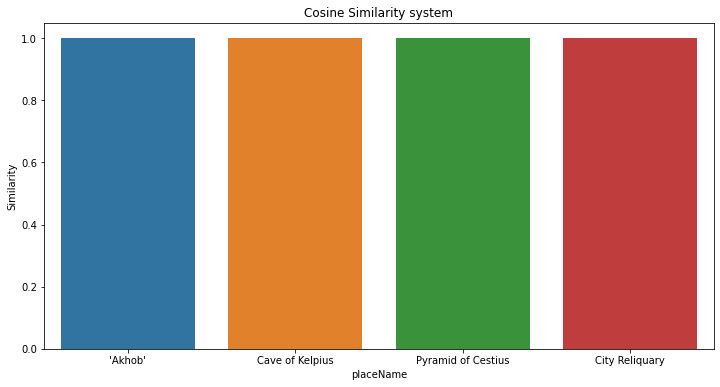

In [92]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_1, x="placeName", y="Similarity",ax=ax).set(title='Cosine Similarity system')

[Text(0.5, 1.0, 'New Scoring System')]

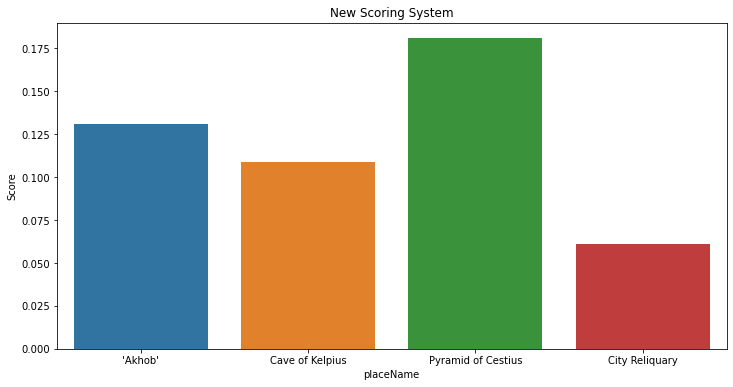

In [93]:

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_2, x="placeName", y="Score",ax=ax).set(title='New Scoring System')

As seen in the two plots above, the new score had a difference as now the more popular place has a higher score. This is better as now people will be recommended the more popular and trendy place when searching for something, which will help differentiate between the places as now we're not only looking at similarity of terms.

#### Heap version

In [1]:
import heapq

In [2]:
def searchEngineHeap(query,k):
    query=re.sub("\s{2,}"," ",query)

    parole=[word for word in stem_text(query)]
    check_parole=[word for word in stem_text(query) if word in vocabulary]

    if len(parole)== len(check_parole):

        indici=list(df[stem_text(query)][(df[stem_text(query)].T != 0).all()].index)




        #Inizialize a list for store the value of the score
        list_score=[]

        #Define a new dataset. In this dataset we will add the cosine similarity.
        data=webdata[webdata.index.isin(indici)][["placeName","placeDesc","placeURL",'numPeopleWant','numPeopleVisited']]
        
        # evaluate the normalizing factors
        p_max = data['numPeopleWant'].abs().max()
        v_max = data['numPeopleVisited'].abs().max()



        #Define a new dataset. In this dataset we will put the tf-idf of the matching documents.
        a=df[df.index.isin(indici)][stem_text(query)]
        a=a.reindex(sorted(a.columns), axis=1) 

        #Evaluate tf-idf of query
        td_idf_query=querty_td_idf(query)
        td_idf_query=td_idf_query.reindex(sorted(a.columns), axis=1) 



        #Evaluate the score between each document and the query.


        for i,row in a.iterrows():

            # compute the factors of the simple cosine similarity
            cos_num=np.dot(td_idf_query.values.flatten(),row.values)
            cos_den=np.linalg.norm(td_idf_query.values.flatten()) * np.linalg.norm(row.values)

            # compute the the scoring factor
            new_adj = 0,5 * row['numPeopleWant']/p_max * row['numPeopleVisited']/v_max

            # evaluate the new score as a combination of the cosine similarity and our corrective factor
            score = cos_num/cos_den * new_adj
            # append the result to a list
            list_score.append((score,row['placeName'])) 
            
        #heapify our list of tuples (score, place name)
        heapq.heapify(list_score)
        list_score = list(list_score)

        for i in range(0,k):
            # print the rows that match by place name in the order given by the list of scores
            print(data[data[['placeName']] == list_score[i][1]][['placeName','placeDesc','placeURL']])


    else:
        print("Can't find a document that contain all the word in the query, check input for misspelled words.")
        



# 4. Visualizing the most relevant places

### Import packages and data

In [2]:
import pandas as pd
import re
from  tqdm import tqdm
df = pd.read_csv("/Users/mattia/Desktop/ADM(Aris)/HM3/address.csv",delimiter="\t")

In the next chunk with the API geolocator we find and assing city and state names to a place that
doesn't have it.  
This is possible because we have the coordinates.

In [28]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [11]:

for i in tqdm(range(0,len(df))):
    if df.loc[i].Address=="Not available" :
        location = geolocator.reverse(str(df.loc[i].placeAlt)+","+str(df.loc[i].placeLong))
        try:
            address = location.raw['address']
        except:
            continue 
        
        if  df.loc[i].City =="Not available" :
            try:
                df["City"][i]=address["city"]
            except:
                pass
        if df.loc[i].State =="Not available" :
            try:
                df["State"][i]=address["country"]
            except:
                pass
df.to_csv("/Users/mattia/Desktop/ADM(Aris)/HM3/address.csv",sep="\t")

  0%|                                                  | 0/7200 [00:00<?, ?it/s]/var/folders/j4/9fk3st2d30g22vff83pj6cnw0000gn/T/ipykernel_1178/4144828238.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["City"][i]=address["city"]
100%|███████████████████████████████████████| 7200/7200 [12:24<00:00,  9.67it/s]


In [24]:
ad = pd.read_csv("address.csv",sep="\t")

# solution from the third point
query_result = ad[ad['placeName'].isin(df_1['placeName'])]

In [25]:
query_result

Unnamed: 0.1  Unnamed: 0           placeName  \
41             41          41             'Akhob'   
127           127         127     Cave of Kelpius   
628           628         628  Pyramid of Cestius   
694           694         694      City Reliquary   

                                             placeTags  numPeopleVisited  \
41                                   installations,art               428   
127  apocalypse,utopia week,cults,aletrail,caves,ec...               490   
628                               catacombs and crypts              1458   
694              collections,history & culture,museums               511   

     numPeopleWant                                          placeDesc  \
41            4185  Imagine the sheer serendipity of finding a wor...   
127           3033  Tucked away in a remote section of Philadelphi...   
628           1697  Egyptomania gripped Rome in the wake of the co...   
694           1632  After your trip to New York, no one is going t...   

                                        placeShortDesc  \
41   James Turrell's total color immersion art inst...   
127  Where America's first doomsday cult awaited th...   
628  The only "Egyptian" pyramid in Europe and the ...   
694  Behind a bodega is a small museum of relics an...   

                                           placeNearby  \
41   'Bliss Dance',Las Vegas Strip Benchmarks,Art-o...   
127  Toleration Statue,The Nervous System of 'Harri...   
628  The Protestant Cemetery,Monte Testaccio,The Av...   
694  The Grundhauser Hero Lending Library,Brooklyn ...   

                                          placeAddress  ...  placeLong  \
41   3720 Las Vegas Blvd South,Suite 103,Las Vegas,...  ...  -115.1718   
127  777-795 Hermit Ln,Philadelphia, Pennsylvania, ...  ...   -75.2016   
628  Pyramid of Caius Cestius,Via Raffaele Persiche...  ...    12.4809   
694  370 Metropolitan Avenue,Brooklyn, New York, 11...  ...   -73.9558   

            createdby                                       placeEditors  \
41   TheStephanieCass  laneikkadenne,nathomas,jondi letnap,corinna,fi...   
127       AaronNetsky  madisun5,sadbread99,SailorAlphaC,MandrewPatink...   
628     Annetta Black  Arthur Pendragon,jonoperth,FWworldtraveler,rom...   
694       Oliver Hong                                                      

    placePubDate                                  placeRelatedLists  \
41    2015-10-23  The World's Top 100 Wonders in 2018,Favorites,...   
127   2016-09-14               Off-Centered Ale Trail: Philadelphia   
628   2010-03-02                                                      
694   2012-02-25                             Unusual Wedding Venues   

                                    placeRelatedPlaces  \
41   ZinkGlobal,Ciderville Music Store,Upplevelsdus...   
127  Ice Cave of Bixby State Preserve,Hermit's Cave...   
628  Nagcarlan Underground Cemetery,Café in the Cry...   
694  Stearns History Museum,Thunder Dome Car Museum...   

                                              placeURL  \
41           https://www.atlasobscura.com/places/akhob   
127  https://www.atlasobscura.com/places/cave-of-ke...   
628  https://www.atlasobscura.com/places/pyramid-of...   
694  https://www.atlasobscura.com/places/city-reliq...   

                     Address                               City          State  
41             Not available                      Not available  United States  
127        777-795 Hermit Ln  Philadelphia, Pennsylvania, 19128  United States  
628            Not available                               Roma          Italy  
694  370 Metropolitan Avenue          Brooklyn, New York, 11211  United States  

[4 rows x 21 columns]

In [31]:
import plotly.express as px
import geopandas as gpd

#geo_df = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


fig = px.scatter_mapbox(query_result,
                        lat=query_result.placeAlt,
                        lon=query_result.placeLong,
                        hover_name=query_result.placeName,
                        hover_data=[query_result.numPeopleVisited,query_result.Address,query_result.City,query_result.State],
                        labels={'numPeopleVisited':'Number of visit',"placeAlt":"Latitude","placeLong":"Longitude"},
                        zoom=1)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### The distribution of all over the places from our data set

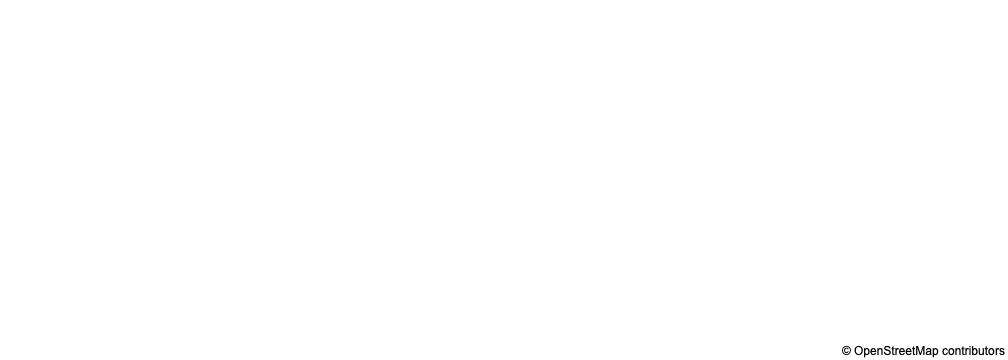

In [3]:
fig = px.scatter_mapbox(df,
                        lat=df.placeAlt,
                        lon=df.placeLong,
                        hover_name=df.placeName,
                        hover_data=[df.numPeopleVisited,df.Address,df.City,df.State],
                        labels={'numPeopleVisited':'Number of visit',"placeAlt":"Latitude","placeLong":"Longitude"},
                        zoom=1)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# 7. Theoretical question

We start from reading the text file and modifying its strucutre: we don't want to visualize all the students' performances for each exam. We simply evaluate the mean of the grades for each student (avoiding the use of mean() function) in N*M steps.

In [1]:
with open('ApplicantsInfo.txt','r',encoding='utf-8') as f:
	line = f.readline().split()
	N = int(line[0])    # numbr of applicants
	M = int(line[1])    # numbr of grades

    # building a list of lists --> each list defines a student's attributes
	rows = []
	for _ in range(N):
		row = f.readline().split()
		score = round(sum([int(x) for x in row[2:M+2]])/M, 2)
		rows.append([row[0],row[1],score])

Now we can proceed with the sorting algorithms used for our task. We introduce three classic sorting algorithms in order of efficiency and we make the following clarifications before we start:

1. we hove the ordering key --> the first one in the avarage score and the second one is the alphanumeric order of the strings containing first and last name;

2. we do not consider the printing running time of the desired output in computing the efficiency of the algorithm

## 7.1 - 7.2

### Selection sort

We use this algorithm for first in order to report a base case sorting method: _selection sort_ (we'll see) is not that efficient from the runnning time point of view but it is an _in-place_ algorithm (i.e. it doesn't need extra space to obtain the solution but simply work the given input with no size variations).

#### Designing the algorithm:

1. First for loop in which we initialize the index of the largest value to the current index
2. we compare the current element with the rest of the elements in the list (iterating over them)
3. we update the max index if one of the comparing conditions is satisfied 
4. we swap the corresponding values (at each iteration we have a partially sorted list)
5. when visited the last element the list will be completely sorted

#### Implementation:

In [3]:
def selection_sort(students,N):
	for i in range(N):
		max_i = i
		for  j in range(i+1,N):

            # first comparison
			if( students[max_i][2] < students[j][2]):
				max_i = j
			elif (students[max_i][2] == students[j][2]):

                # second comparison
				if((students[max_i][0]+students[max_i][1]).lower() > (students[j][0] +students[j][1]).lower()):
					max_i = j
		
		# swapping the elements in the list
		students[i],students[max_i] = students[max_i],students[i]
	return students

#### Analysis of the algorithm:

The running time evaluation is pretty easy:
>- we iterate N times over the outer loop
>- at the i-th step we iterate N-i times over the inner loop
>- tasks like swapping operations, assigning values and checking conditions are completed in constant time 

Running-time: 

\begin{align*}
T(N)=\sum_{i=0}^{N-1}(N-i)+c 
\end{align*}

\begin{align*}
k = N-i
\end{align*}

\begin{align*}
T(N)=\sum_{k=1}^{N}k+c=\frac{N(N-1)}{2}+c = O(N^2)
\end{align*}

### Merge sort

This algorithm is much more efficient than the previous one even though it is of the _not-in-place_ type: it uses a significantly larger portion of memory than the input, exploiting auxiliary data structures to construct the solution.
It is based on the _divide and conquer_ technique since:
1. we divide the input object in two halves
2. we solve the two subproblems separately by recursion
3. we combine the two results in an overall solution

#### Designing the algorithm:

1. separate the rows of the file in two halves;
2. sort each half separately by recursion, comparing grades and names (two grades of comparition);
3. base case of the recursion -> when the input size is two we have a trivial comparition between two values (and eventually a switch);
4. combine the results of each recursion -> merge the solutions of the subproblems comparing grades and names of the elements of each half. 

#### Implementation

In [10]:
def merge_sort(rows):
	if len(rows) > 1:
		mid  = len(rows)//2
		left =  rows[:mid]
		right = rows[mid:]
		merge_sort(left)
		merge_sort(right)
		il= 0
		ir= 0 
		i = 0
		while(il < len(left) and ir <len(right)):
			if( left[il][2] > right[ir][2]):
				rows[i] = left[il]
				il +=1
			elif(left[il][2] == right[ir][2]):
				if(left[il][0]+left[il][1]).lower() < (right[ir][0] +right[ir][1]).lower():
					rows[i]  = left[il]
					il +=1
				else:
					rows[i]  = right[ir]
					ir +=1
			else:
				rows[i] = right[ir]
				ir +=1
			i+=1
		
		while( il < len(left)):
			rows[i] = left[il]
			il += 1
			i += 1
			
		while( ir<len(right)):
			rows[i] = right[ir]
			ir += 1
			i += 1
			
	return rows

#### Analysis of the algorithm:

For the evaluation of the running time consider that:
>- each condition runs in constant time;
>- given the size of the input N we have (after the recursion calls) that the sum of the steps for the three while loops is c * 2 * (N/2), i.e. c*N, in the worst case scenario ;
>- at the generic i-th recursion we have an input of dimension N/2^(i), that implies c*N/2^(i) steps to sum to the the steps of the previuos recursive calls. 

\begin{align*}
T(N) = 2 \cdot T(N/2) +c\cdot N = 2 \cdot (2  T(N/4)+c\cdot N/2) +c \cdot N =
\end{align*}

\begin{align*}
=2 \cdot (2  (2 T(N/8)+ c\cdot N/4) +c\cdot N/2) +c \cdot N =
\end{align*}

\begin{align*}
=2^{i} \cdot T(N/2^{i})+ c (2^{i-1}\cdot (N/2^{i-1}) + 2^{i-2}\cdot (N/2^{i-2}) + \cdot \cdot \cdot + N) =
\end{align*}

\begin{align*}
=2^{k} \cdot T(N/2^{k})+ c \cdot k \cdot N 
\end{align*}

Where k is the number defined as: 

\begin{align*}
k : N/2^{k}=1 
\end{align*}

\begin{align*}
k= log_{2}(N)
\end{align*}

\begin{align*}
T(N) = N\cdot T(1) + N\cdot log_{2}(N) = O(N\cdot log(N))
\end{align*}


### Quick sort

_Quick sort_ is pretty similar to the _Merge Sort_ algorithm since is based on the _divide and conquer_ technique. The main difference is that we use a pivot element which defines the the two subproblems for each recursion: we have one subproblem for the partition at the right of the pivot point and another subproblem for the other partition (at left of the pivot). 

#### Designing the algorithm:

1. base case of the recursion -> the partition of the problem has size = 1 (only one element to check);
2. we pick the pivot element at each recursion as the last element of the partition (at the first quick sort call will be the last row itself);
when building the two partitions we check through all over the elements that we want to partition and we put all the grater elements on the left and all the smaller on the right of the pivot point;
3. so we put the pivot point in a correct position in the partition (that will be entirely sorted).

In [11]:
def partition(array, mini, maxi):
    
    # Pick the pivot
    pivot = array[maxi]
    pivot_mean = pivot[2]
    pivot_name = pivot[0].lower() + pivot[1].lower()
  
    # Pointer for greater element
    i = mini - 1
  
    # Traverse through all elements
    # compare each element with pivot
    for j in range(mini, maxi):
        if array[j][2] > pivot_mean:
            # If a row with mean greater than mean at pivot is found
            # swap it with the row with smaller mean pointed by i
            i = i + 1
  
            # Swapping element at i with element at j
            (array[i], array[j]) = (array[j], array[i])

        elif array[j][2] == pivot_mean:
            # If a row with mean equal to the mean at pivot is found
            if array[j][0].lower() + array[j][1].lower() <= pivot_name:
                # check if a row with name+surname grater than name+surname at pivot is found
                # swap it with the row with smaller mean pointed by i
                i = i + 1
    
                # Swapping element at i with element at j
                (array[i], array[j]) = (array[j], array[i])
  
    # Swap the pivot element with 
    # e greater element specified by i
    (array[i + 1], array[maxi]) = (array[maxi], array[i + 1])
  
    # Return the position from where partition is done
    return i + 1
  
# Function to perform quicksort
  
  
def quick_sort(rows, mini, maxi):
    # base case of the recursion is when maxi == mini --> the partition of rows consists of a single row
    if mini < maxi:
  
        # Find pivot row 
        part = partition(rows, mini, maxi)
  
        # Recursive call on the left of pivot -> rows with smaller mean/name
        quick_sort(rows, mini, part - 1)
  
        # Recursive call on the right of pivot -> rows with greater mean/name
        quick_sort(rows, part + 1, maxi)

#### Analysis of the algorithm:

For the evaluation of the running time consider that:
>- the function that creates the partition at each recursion takes linear time;
>- we have two recursive calls for each subproblem;
>- we have the worst case scenario when we pick at each recursion the smallest or greatest row of all the rows in the file i.e. when the rows are arleady sorted (in ascending or descending order). 

At a random recursive call, given k as the number of elemnts greater than the pivot we have: 
\begin{align*}
T(N) = T(k) + T(N-k-1) + N + c
\end{align*}

In the worst case scenario we have the maximum number of recursion calls so:

\begin{align*}
T(N) = T(0) + T(N-1) + N + c = 
\end{align*}

\begin{align*}
= T(0) + T(1) + T(N-2) + 2 \cdot (N + c) =
\end{align*}

\begin{align*}
= N \cdot c + N \cdot (N + c) = O(N^2)
\end{align*}

In [5]:
import time

In [12]:
start_quick = time.time()
quick_sort(rows, 0, len(rows) - 1)
end_quick = time.time()

deltaQ = end_quick-start_quick
print(f"Quick sort took: {deltaQ} seconds")


Quick sort took: 0.3232548236846924 seconds


In [13]:
start_merge = time.time()
merge_sort(rows)
end_merge = time.time()

deltaM = end_merge-start_merge
print(f"Merge sort took: {deltaM} seconds")


Merge sort took: 0.2827773094177246 seconds


In [8]:
start_select = time.time()
selection_sort(rows, N)
end_select = time.time()

deltaS = end_select-start_select
print(f"Selection sort took: {deltaS} seconds")


Selection sort took: 212.85640501976013 seconds


Given the requirement to display the results in terms of execution time, we find it uninteresting to include in the graphical comparison the execution time of the selection sort ( visibly much larger than the other two by at least three orders of magnitude).

In [28]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(
            x=[deltaM, deltaQ],
            y=['Merge sort', 'Quick sort'],
            orientation='h'))

fig.show()

## 7.3

In our opinion, the best algorithm is the quick sort algorithm. Our reasoning is based on various aspects:

1. For first we can exclude the _selection sort_ -> it is known to be inefficient (just look at the running time of our implementation) and so are similar algorithms (e.g. _insertion sort_).

2. In general among sorting algorithms there are techniques for constructing output that are not based on comparing values (as in the case of the algorithms we proposed above). Algorithms like _counting sort_ hash the value in a temporary count array and uses them for sorting. They are pretty efficient algorithm and they run in linear time thanks to a certain set of assumptions, but we demostrate below that in our case is not possible to implement an efficient version of the _counting sort_.

3. We just have to check which is better between the Merge sort and the quick sort.


### Why we can't implement an efficient Counting sort

Counting sort is a pretty efficient algorithm and it is based on the fact that we have a set of _a priori_ information: the attributes on which we have to base the sorting can vary in a finite set of values of which we already know the extremes. In our case we possess this information a priori even though we have to work on hashed versions of our sorting keys.

#### Sorting by mean

We can extrapolate a priori information about the maximum mean and the minimum mean of the applicants' clump, and by hashing the value of the mean into a number two orders of magnitude higher, we will have a difference of ... steps between the extreme values.

In [29]:
grades = set([row[2] for row in rows])
mini = int(min(grades)*100)
maxi = int(max(grades)*100)

print(f'The gap between the max mean and the min mean is of {maxi-mini} numbers')

The gap between the max mean and the min mean is of 98 numbers


In [58]:
def counting_sort(rows):
    size = len(rows)
    output = [0] * size

    # identify all the spectre of possible means of grades
    grades = set([row[2] for row in rows])
    mini = int(min(grades)*100)
    maxi = int(max(grades)*100)
    # Initialize count array
    counter_grades = {grade : 0 for grade in range(int(min(grades)*100), int(max(grades)*100+1))}
    # Initialize count array

    # Store the count of each elements in count array
    for i in range(0, size):
        counter_grades[rows[i][2]*100] += 1

    # Store the cummulative count
    i = mini +1
    while i <= maxi:
        counter_grades[i] += counter_grades[i - 1]
        i+=1

    # Find the index of each element of the original array in count array
    # place the elements in output array
    i = size - 1
    while i >= 0:
        output[counter_grades[rows[i][2]*100] - 1] = rows[i]
        counter_grades[rows[i][2]*100] -= 1
        i -= 1

    # Copy the sorted elements into original array
    for i in range(0, size):
        rows[i] = output[size-(i+1)]

    return(rows)

In [59]:
counting_sort(rows)

[['Emily', 'Crispin', 24.49],
 ['Patricia', 'Witten', 24.49],
 ['Doreen', 'Richmond', 24.45],
 ['Bruce', 'Johnson', 24.45],
 ['David', 'Niederberger', 24.44],
 ['Keisha', 'Keene', 24.44],
 ['Steven', 'Boston', 24.44],
 ['John', 'Johnson', 24.42],
 ['Melody', 'Sanchez', 24.42],
 ['Marvin', 'Ramirez', 24.42],
 ['Ida', 'Mccabe', 24.41],
 ['Edith', 'Lehtonen', 24.41],
 ['Joshua', 'Reece', 24.41],
 ['Luisa', 'Young', 24.41],
 ['Manuel', 'Sullinger', 24.41],
 ['Violet', 'Paulino', 24.4],
 ['Particia', 'Mirabal', 24.4],
 ['Cara', 'Baird', 24.4],
 ['Betty', 'Kubiak', 24.4],
 ['Mattie', 'Salinas', 24.4],
 ['Josephine', 'Young', 24.39],
 ['Amy', 'Walker', 24.39],
 ['Marie', 'Wall', 24.39],
 ['Jeffrey', 'Johnson', 24.39],
 ['Kelsey', 'Mcneill', 24.39],
 ['Kathleen', 'Whaley', 24.39],
 ['Latoya', 'Stemp', 24.39],
 ['Harry', 'Lupu', 24.39],
 ['Richard', 'Parker', 24.39],
 ['Ruth', 'Heimsness', 24.38],
 ['Rose', 'Mcpeak', 24.38],
 ['Desiree', 'Paul', 24.38],
 ['David', 'Kerns', 24.38],
 ['Norma', 'S

#### Sorting by name+surname

In this case to compare the strings containing the first and last names of the various students we make a particular hash function: we define for each student a score given by the unicode values of the individual characters contained in the corresponding names. We then extrapolate the highest score and the lowest score and then calculate the maximum distance between these sums of unicode values. Then we implement an algorithm very similar to the previous one.

This type algorithm should run in O(k + N) time where k is the number of possible values that the sorting key can take. The problem exists the moment we try to implement a counting sort according to multiple sort keys and according to different directions! 
In fact, in that case we would have to implement a second counting sort algorithm for sorting by name and then apply this second algorithm to all partitions of the result of the previous algorithm (grouping by mean the rows already sorted). In this way, the overall implementation achieves a much higher computational cost than that obtained for the other algortims in the notebook.

### Merge sort vs Quick sort

As we can see above, in terms of worst-case complexity the Merge sort wins as it has a running time O(N logN). In reality, however, the difference in terms of the running time of the two implementations is practically zero (a few hundredths of a second) and sometimes the quick sort leads to the same solution in the same or slightly less time. This is due to the fact that merge sort and quick sort have the same average running time and that is O(N logN). So merge sort does not improve its performance for random inputs while quick sort does. Furthermore, the latter is an in-place type of algorithm and involves minimal memory allocation.

## 7.5

### MapReduce

In the last years a new software stack is evolved to manage huge amounts of data quickly. The main aspects of this new software stack are:
>- COMPUTING CLUSTERS -> large collections of commodity hardware that allow programming systems to get parallelism;
>- DISTRIBUTED FILE SYSTEMS -> consist of larger units than disk blocks in conventional operating systems and provide replication and redundancy of data (robust to failures);
>- MapReduce -> a style of computing that enables calculations on large-scale data to be performed on computing clusters.

MapReduce process consits of:
1. MAP TASKS -> they turn a given chunk of a file into a sequence of key-values pairs;
2. GROUPING BY KEYS -> a master controller (one of the compute nodes) collects key-value pairs, sort by keys and directs pairs with the same keys to the same raduce workers;
3. REDUCE TASKS -> it works on a key and a list of values and applies a function to this list of values.

Designing our MapReduce:

1. the first map task works on all the rows (except the first one) and returns a list of elements for each row;
2. the second map task takes in input a chunk of lists (rows) and returns key-value pairs with the mean of the grades as key and student's name as value;
3. the reduce task should simply group  the inputs by key and assign each key a list of values (names related to the sasme mean of grades), BUT this task collaspes to the previous map task (which indeed groups directly by key). It's frequent that reduce tasks collapse in the map tasks when the function that they apply on a group of values is associative and commutative (but in this case we don't even have a reduce task);
4. since we don't need any operation outside of sorting and the master controller can handle this task by himself we simply address this task to the master node.

Below we report a scheme which represents our MapReduce algorithm.

![tree](ADMP18.png)

We implemented the MapReduce algorithm in PySpark on a AWS Elastic MapReduce Cluster and we can clearly see that we obtain the same results that from the classic sorting algorithms above.
What we can claim is that MapReduc is a programming technique that takes place in order to completely exploit the advantages offered by the a Distributed File System (DFS) and a Cumputing Clusters. But parallel programming is reallly useful only for datasets the satisfy two main conditions:
1. enourmous files;
2. files rarely updated (read for calculation and possibly additional data is appended).

In this case ApplicantsInfo.txt is not that big since we only have 50.000 rows (with 1002 elements each) so the weight of the flaws of this method is felt more:
>- when designing a MapReduce algorithm a critcal point is the cost of communication between nodes;
>- the process is probably slowed down by a set of information that the worker nodes exchange with the master node to synchronize and control the process and actual task completion;
>- moreover, each map task involves splitting the file into chunks and replicating chunks (usually three times) in different compute nodes for robustness to failures;
>- finally at each map and reduce operation the nodes momentarily save the results obtained in their own memory and pyspark works on RDD, so at the end of the process we have an additional time factor due to storing the result in an additional RDD.

PySpark notebook showed that our mapReduce implementation took 19.42 seconds so we have a less efficient algorithm compared to Quick sort or Merge sort.

The part below comes from a notebook runned on a PySpark kernel in an AWS EMR and then merged with the above notebook using the _nbformat_ library -> DO NOT RUN THE CODE BELOW THIS CELL!

WARNING: we decided to only print the sorted file resulting from the mapReduce algorithm bat every algorithm get the same result

### Opening the text file from a s3 bucket on an EMR cluster

In [9]:
appl = sc.textFile('s3://hm3adm2022en/ApplicantsInfo.txt')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# let's start from the visualization of the structure of our file
appl.take(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['50000 1000', 'Richard Scott 23 26 30 29 27 26 19 27 21 25 29 23 29 20 19 22 22 22 22 19 27 28 26 20 29 30 21 19 24 28 21 24 28 24 19 29 24 24 27 29 22 21 21 27 19 21 23 21 19 25 21 22 22 26 19 27 28 20 21 20 20 23 24 21 24 24 20 29 18 30 19 25 26 30 23 24 21 24 22 25 20 28 20 21 30 20 20 25 23 30 28 29 23 27 20 24 26 29 21 22 20 18 24 19 24 28 19 26 19 19 28 20 20 21 20 21 24 29 24 22 30 19 24 30 22 24 28 21 21 25 25 20 21 29 19 29 26 25 28 27 28 29 27 21 28 18 24 18 28 24 22 19 24 26 28 27 24 24 27 29 26 26 18 19 29 27 24 27 22 25 23 27 20 28 25 19 28 22 29 30 21 28 30 21 21 26 19 26 20 18 26 27 28 29 23 29 24 21 22 24 29 29 26 29 19 25 29 21 24 29 25 21 26 21 19 20 20 27 19 21 18 24 20 19 18 23 22 26 22 26 19 25 25 26 24 21 30 19 19 21 29 24 26 21 30 25 29 23 19 23 26 26 28 20 24 24 22 21 25 23 21 25 28 23 23 30 26 23 24 22 26 23 24 29 28 24 28 22 19 25 20 19 29 26 19 20 20 25 21 27 22 23 28 26 18 20 26 21 29 28 22 19 23 18 25 18 22 29 30 26 18 27 25 23 23 26 30 25 28 19 20 22 22 2

In [31]:
# we want to extract the first line of the file -> quantitative info about the rest of the rows in the file
first = appl.take(1)
first

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['50000 1000']

# MapReduce process

In [58]:
# 1. filter the first line and exclude it from our mapReduce algorithm
# 2. simply we map each row in a list
# 3. we have to parse the grades in floats and evaluate the mean -> the mean is the key of our output and the Value is a text with name and surname
# 4. we order by the mean (decrescent order) and by name-surname (alphabetical order)


appl.filter(lambda row: row != first[0])\
.map(lambda row: row.split())\
.map(lambda row : (round(sum([float(grade) for grade in row[2:]])/int(first[0].split()[1]),2), row[0]+" "+row[1]))\
.takeOrdered(int(first[0].split()[0]), lambda x: (-x[0],x[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(24.49, 'Emily Crispin'), (24.49, 'Patricia Witten'), (24.45, 'Bruce Johnson'), (24.45, 'Doreen Richmond'), (24.44, 'David Niederberger'), (24.44, 'Keisha Keene'), (24.44, 'Steven Boston'), (24.42, 'John Johnson'), (24.42, 'Marvin Ramirez'), (24.42, 'Melody Sanchez'), (24.41, 'Edith Lehtonen'), (24.41, 'Ida Mccabe'), (24.41, 'Joshua Reece'), (24.41, 'Luisa Young'), (24.41, 'Manuel Sullinger'), (24.4, 'Betty Kubiak'), (24.4, 'Cara Baird'), (24.4, 'Mattie Salinas'), (24.4, 'Particia Mirabal'), (24.4, 'Violet Paulino'), (24.39, 'Amy Walker'), (24.39, 'Harry Lupu'), (24.39, 'Jeffrey Johnson'), (24.39, 'Josephine Young'), (24.39, 'Kathleen Whaley'), (24.39, 'Kelsey Mcneill'), (24.39, 'Latoya Stemp'), (24.39, 'Marie Wall'), (24.39, 'Richard Parker'), (24.38, 'Amanda Williams'), (24.38, 'Daryl Singer'), (24.38, 'David Kerns'), (24.38, 'Desiree Paul'), (24.38, 'Jackson Klopfer'), (24.38, 'Jeramy Galicia'), (24.38, 'Juan Gonzalez'), (24.38, 'Kyle Carlson'), (24.38, 'Mary Nguyen'), (24.38, 'Nor